In [1]:
!pip install pandas_profiling==2.8.0

     |████████████████████████████████| 259 kB 4.8 MB/s 
     |████████████████████████████████| 675 kB 30.7 MB/s 
     |████████████████████████████████| 4.7 MB 30.3 MB/s 
     |████████████████████████████████| 59 kB 4.6 MB/s 
     |████████████████████████████████| 812 kB 42.5 MB/s 
     |████████████████████████████████| 38.1 MB 1.5 MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=01ef8ead54f14ee512d89fd467d8bc42790df278a9b26f435015041f06d1f15d
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d201a26d0bd3ee8655
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295207 sha256=b69c18bee5484dc918324c5230a69f3a770a376682669d7af3a6f86158726e4f
  Stored in directory: /root/.cache/pip/wheels/4c/d5/59/5e3e297533ddb09407769762985d134135064c6831e29a914e
Successfully built htmlmin imagehash
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstallin

In [2]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 51 kB/s 


# Data Collection

In [3]:
import os
import tarfile
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
PATH = os.path.join("datasets", "titanic")
URL = DOWNLOAD_ROOT + "datasets/titanic/train.csv"

def fetch_titanic_data(url=URL, path=PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    csv_path = os.path.join(path, "titanic.csv")
    urllib.request.urlretrieve(url, csv_path)

def load_titanic_data(path=PATH):
    csv_path = os.path.join(path, "titanic.csv")
    return pd.read_csv(csv_path)

See the column explanation: https://www.kaggle.com/c/titanic/data

In [4]:
fetch_titanic_data()
titanic = load_titanic_data()
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
from pandas_profiling import ProfileReport

titanic_profile = ProfileReport(titanic, title = 'Titanic Dataset Profile', explorative = True)
titanic_profile.to_file('titanic_profile.html')

Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

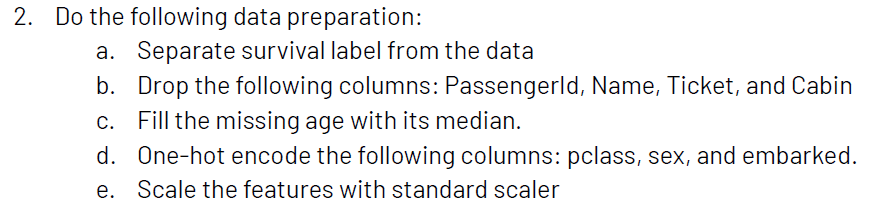

# Data Preparation

In [7]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
labels = titanic['Survived'].value_counts().to_frame().reset_index()
labels.columns = ['Survived', 'Count']
labels['Survived'].replace({0: 'No', 1: 'Yes'}, inplace = True)
labels

,Survived,Count
0,No,549
1,Yes,342


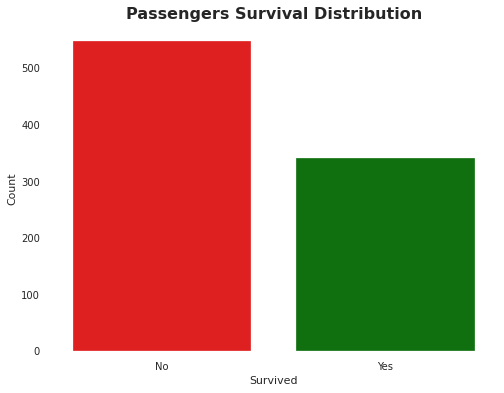

In [10]:
plt.figure(figsize = (8, 6))
sns.barplot(x = 'Survived', y = 'Count', data = labels,
            palette = ['red', 'green'])
plt.title('Passengers Survival Distribution', fontsize = 16, fontweight = 'bold')
plt.show()

We can select the accuracy to be the metrics since the dataset is quite balanced.

In [11]:
X = titanic.drop('Survived', axis = 'columns')
y = titanic['Survived']

Since there are only 2 rows with missing data in the `Embarked` column, we can drop them immediately because in one-hot encoding, it is quite redundant to have 1 additional features.

# Drop Irrelevant Columns

In [12]:
unwanted_columns = ['PassengerId', 'Name', 'Ticket', 'Cabin']
X.drop(unwanted_columns, axis = 'columns', inplace = True)

# Fill The Age Column With Median

In [13]:
def check_distribution(df, column):
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))
    fig.suptitle('Distribution of ' + column, fontsize = 'xx-large', fontweight = 'bold')

    sns.histplot(x = column, data = df, ax = ax[0], kde = True)
    ax[0].set_title('Histogram', color = 'blue', fontweight = 'bold')
    ax[0].set_xlabel(column, fontweight = 'bold')

    sns.violinplot(x = column, data = df, ax = ax[1])
    ax[1].set_title('Violin Plot', color = 'blue', fontweight = 'bold')
    ax[1].set_xlabel(column, fontweight = 'bold')

    plt.show()

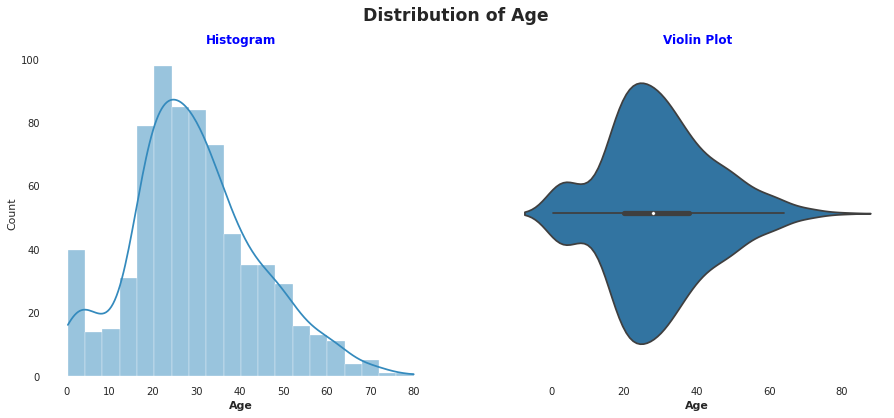

In [14]:
check_distribution(titanic, 'Age')

In [15]:
X['Age'].fillna(np.nanmedian(X['Age']), inplace = True)

# One-Hot Encoding

In [16]:
from sklearn.preprocessing import OneHotEncoder

def encode_categorical_columns(df, column):
    onehot_encoder = OneHotEncoder(sparse = False)
    encoded_column = onehot_encoder.fit_transform(df[[column]])
    encoded_column_df = pd.DataFrame(encoded_column, 
                                     columns = [column + '_' + str(x) for x in df[column].unique()])
    
    joined_df = df.join(encoded_column_df)
    joined_and_cleaned_df = joined_df.drop(column, axis = 1)
    return joined_and_cleaned_df

In [17]:
categorical_columns = ['Pclass', 'Sex', 'Embarked']

for col in categorical_columns:
    X = encode_categorical_columns(X, col)

In [18]:
X

,Age,SibSp,Parch,Fare,Pclass_3,Pclass_1,Pclass_2,Sex_male,Sex_female,Embarked_S,Embarked_C,Embarked_Q,Embarked_nan
0,22.0,1,0,7.2500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,38.0,1,0,71.2833,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,26.0,0,0,7.9250,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,35.0,1,0,53.1000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,35.0,0,0,8.0500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,0,0,13.0000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
887,19.0,0,0,30.0000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
888,28.0,1,2,23.4500,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
889,26.0,0,0,30.0000,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


# Missing Values Check Before Modelling

In [19]:
X.isnull().sum()

Age             0
SibSp           0
Parch           0
Fare            0
Pclass_3        0
Pclass_1        0
Pclass_2        0
Sex_male        0
Sex_female      0
Embarked_S      0
Embarked_C      0
Embarked_Q      0
Embarked_nan    0
dtype: int64

# Features Scaling

In [20]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
scaled_features = standard_scaler.fit_transform(X)
X_scaled = pd.DataFrame(scaled_features, columns = X.columns)

In [21]:
X_scaled

,Age,SibSp,Parch,Fare,Pclass_3,Pclass_1,Pclass_2,Sex_male,Sex_female,Embarked_S,Embarked_C,Embarked_Q,Embarked_nan
0,-0.565736,0.432793,-0.473674,-0.502445,-0.565685,-0.510152,0.902587,-0.737695,0.737695,-0.482043,-0.307562,0.619306,-0.047431
1,0.663861,0.432793,-0.473674,0.786845,1.767767,-0.510152,-1.107926,1.355574,-1.355574,2.074505,-0.307562,-1.614710,-0.047431
2,-0.258337,-0.474545,-0.473674,-0.488854,-0.565685,-0.510152,0.902587,1.355574,-1.355574,-0.482043,-0.307562,0.619306,-0.047431
3,0.433312,0.432793,-0.473674,0.420730,1.767767,-0.510152,-1.107926,1.355574,-1.355574,-0.482043,-0.307562,0.619306,-0.047431
4,0.433312,-0.474545,-0.473674,-0.486337,-0.565685,-0.510152,0.902587,-0.737695,0.737695,-0.482043,-0.307562,0.619306,-0.047431
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,-0.181487,-0.474545,-0.473674,-0.386671,-0.565685,1.960202,-1.107926,-0.737695,0.737695,-0.482043,-0.307562,0.619306,-0.047431
887,-0.796285,-0.474545,-0.473674,-0.044381,1.767767,-0.510152,-1.107926,1.355574,-1.355574,-0.482043,-0.307562,0.619306,-0.047431
888,-0.104637,0.432793,2.008933,-0.176263,-0.565685,-0.510152,0.902587,1.355574,-1.355574,-0.482043,-0.307562,0.619306,-0.047431
889,-0.258337,-0.474545,-0.473674,-0.044381,1.767767,-0.510152,-1.107926,-0.737695,0.737695,2.074505,-0.307562,-1.614710,-0.047431


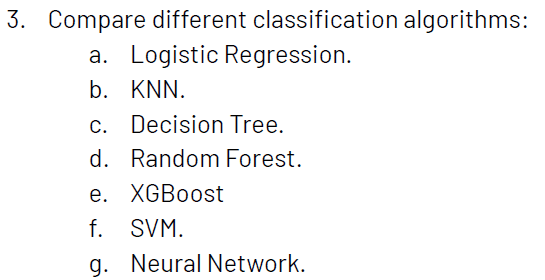

# Modelling

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

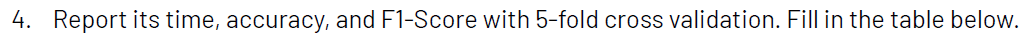

In [23]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

In [24]:
def cross_validate_model(model_class, X, y):
    model = model_class
    cross_val_scores = cross_validate(model, X, y, scoring = ['accuracy', 'f1'], cv = 5)

    # Display Model Name, Time, Accuracy and F1-Score
    print('\nModel: {}'.format(str(model_class).strip('()')))
    print('=' * 70)

    print('Time: {}'.format(cross_val_scores['fit_time']))
    print('Average Time: {}'.format(np.mean(cross_val_scores['fit_time'])))
    print('Standard Deviation of Time: {}'.format(np.std(cross_val_scores['fit_time'])))

    print('\nAccuracy: {}'.format(cross_val_scores['test_accuracy']))
    print('Average Accuracy: {}'.format(np.mean(cross_val_scores['test_accuracy'])))
    print('Standard Deviation of Accuracy: {}'.format(np.std(cross_val_scores['test_accuracy'])))

    print('\nF1 Score: {}'.format(cross_val_scores['test_f1']))
    print('Average F1 Score: {}'.format(np.mean(cross_val_scores['test_f1'])))
    print('Standard Deviation of F1 Score: {}\n'.format(np.std(cross_val_scores['test_f1'])))

In [25]:
cross_validate_model(LogisticRegression(), X_scaled, y)


Model: LogisticRegression
Time: [0.024827   0.01355743 0.01899529 0.0123899  0.01275063]
Average Time: 0.01650404930114746
Standard Deviation of Time: 0.0047994747803322465

Accuracy: [0.78212291 0.78651685 0.78651685 0.76966292 0.83146067]
Average Accuracy: 0.7912560416797438
Standard Deviation of Accuracy: 0.021028596265131566

F1 Score: [0.71532847 0.71641791 0.72058824 0.672      0.765625  ]
Average F1 Score: 0.7179919225790327
Standard Deviation of F1 Score: 0.029666409812501637



In [26]:
model_classes = [LogisticRegression(), KNeighborsClassifier(), DecisionTreeClassifier(), 
                 RandomForestClassifier(), XGBClassifier(), SVC(), MLPClassifier()]

for model in model_classes:
    cross_validate_model(model, X_scaled, y)


Model: LogisticRegression
Time: [0.02089524 0.02002263 0.02150869 0.0131228  0.01370215]
Average Time: 0.017850303649902345
Standard Deviation of Time: 0.0036587139670992952

Accuracy: [0.78212291 0.78651685 0.78651685 0.76966292 0.83146067]
Average Accuracy: 0.7912560416797438
Standard Deviation of Accuracy: 0.021028596265131566

F1 Score: [0.71532847 0.71641791 0.72058824 0.672      0.765625  ]
Average F1 Score: 0.7179919225790327
Standard Deviation of F1 Score: 0.029666409812501637


Model: KNeighborsClassifier
Time: [0.00511575 0.00501299 0.00511789 0.0050714  0.00884891]
Average Time: 0.00583338737487793
Standard Deviation of Time: 0.0015082416676024178

Accuracy: [0.7877095  0.7752809  0.8258427  0.81460674 0.81460674]
Average Accuracy: 0.8036093151716779
Standard Deviation of Accuracy: 0.018928884843330756

F1 Score: [0.70769231 0.70149254 0.75968992 0.72727273 0.75555556]
Average F1 Score: 0.7303406100629287
Standard Deviation of F1 Score: 0.023881978234782393


Model: Decisio

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



Model: MLPClassifier
Time: [1.82821012 3.10219073 3.68271589 3.09513307 3.49617577]
Average Time: 3.0408851146697997
Standard Deviation of Time: 0.647536593217112

Accuracy: [0.81005587 0.82022472 0.8258427  0.79213483 0.87640449]
Average Accuracy: 0.8249325214989642
Standard Deviation of Accuracy: 0.028175731286583537

F1 Score: [0.734375   0.74193548 0.75590551 0.67826087 0.828125  ]
Average F1 Score: 0.7477203730494418
Standard Deviation of F1 Score: 0.048100077090407575



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [27]:
times, accuracy_scores, f1_scores = [], [], []
for model in model_classes:
    cross_val_scores = cross_validate(model, X_scaled, y, scoring = ['accuracy', 'f1'], cv = 5)
    times.append(np.mean(cross_val_scores['fit_time']))
    accuracy_scores.append(np.mean(cross_val_scores['test_accuracy']))
    f1_scores.append(np.mean(cross_val_scores['test_f1']))

model_results_df = pd.DataFrame({
    'Classifier': [str(model).strip('()') for model in model_classes],
    'Time': times,
    'Accuracy': accuracy_scores,
    'F1-Score': f1_scores
}).sort_values('Accuracy', ascending = False)

model_results_df

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

,Classifier,Time,Accuracy,F1-Score
6,MLPClassifier,2.705893,0.827199,0.748848
5,SVC,0.045679,0.821549,0.731845
4,XGBClassifier,0.151924,0.819321,0.746597
3,RandomForestClassifier,0.580698,0.808091,0.742259
1,KNeighborsClassifier,0.015989,0.803609,0.730341
0,LogisticRegression,0.049740,0.791256,0.717992
2,DecisionTreeClassifier,0.007756,0.790126,0.721781


# Add Some Baseline Models

In [28]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier

In [29]:
for model in [LGBMClassifier(), AdaBoostClassifier(), CatBoostClassifier()]:
    model_classes.append(model)

model_classes

[LogisticRegression(),
 KNeighborsClassifier(),
 DecisionTreeClassifier(),
 RandomForestClassifier(),
 XGBClassifier(),
 SVC(),
 MLPClassifier(),
 LGBMClassifier(),
 AdaBoostClassifier(),

In [30]:
times, accuracy_scores, f1_scores = [], [], []
model_names = [str(model).strip('()') for model in model_classes]
model_names[9] = 'CatBoostClassifier'
for model in model_classes:
    cross_val_scores = cross_validate(model, X_scaled, y, scoring = ['accuracy', 'f1'], cv = 5)
    times.append(np.mean(cross_val_scores['fit_time']))
    accuracy_scores.append(np.mean(cross_val_scores['test_accuracy']))
    f1_scores.append(np.mean(cross_val_scores['test_f1']))

model_results_df = pd.DataFrame({
    'Classifier': model_names,
    'Time': times,
    'Accuracy': accuracy_scores,
    'F1-Score': f1_scores
}).sort_values('Accuracy', ascending = False).reset_index()

model_results_df

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

Streaming output truncated to the last 5000 lines.
4:	learn: 0.6656477	total: 51.6ms	remaining: 10.3s
5:	learn: 0.6597605	total: 52.6ms	remaining: 8.71s
6:	learn: 0.6538428	total: 53.6ms	remaining: 7.61s
7:	learn: 0.6490485	total: 54.7ms	remaining: 6.79s
8:	learn: 0.6445966	total: 55.6ms	remaining: 6.13s
9:	learn: 0.6396382	total: 56.7ms	remaining: 5.61s
10:	learn: 0.6352731	total: 57.6ms	remaining: 5.18s
11:	learn: 0.6303930	total: 58.7ms	remaining: 4.83s
12:	learn: 0.6253777	total: 59.7ms	remaining: 4.54s
13:	learn: 0.6228868	total: 60.4ms	remaining: 4.26s
14:	learn: 0.6180746	total: 61.5ms	remaining: 4.04s
15:	learn: 0.6134051	total: 62.5ms	remaining: 3.85s
16:	learn: 0.6093111	total: 63.7ms	remaining: 3.68s
17:	learn: 0.6050138	total: 64.7ms	remaining: 3.53s
18:	learn: 0.6008314	total: 65.8ms	remaining: 3.4s
19:	learn: 0.5963716	total: 66.6ms	remaining: 3.27s
20:	learn: 0.5920568	total: 67.8ms	remaining: 3.16s
21:	learn: 0.5882039	total: 68.8ms	remaining: 3.06s
22:	learn: 0.5845909

,index,Classifier,Time,Accuracy,F1-Score
0,7,LGBMClassifier,0.056942,0.827186,0.767138
1,6,MLPClassifier,1.131271,0.823809,0.745583
2,9,CatBoostClassifier,1.453630,0.822679,0.749130
3,5,SVC,0.022797,0.821549,0.731845
4,4,XGBClassifier,0.053643,0.819321,0.746597
5,3,RandomForestClassifier,0.192507,0.812592,0.746796
6,8,AdaBoostClassifier,0.093422,0.807024,0.746278
7,1,KNeighborsClassifier,0.005381,0.803609,0.730341
8,0,LogisticRegression,0.013845,0.791256,0.717992
9,2,DecisionTreeClassifier,0.004334,0.785651,0.718198


# Hyperparameter Tuning

Tune the highest score for baseline model (based on accuracy). 

In [31]:
from sklearn.model_selection import GridSearchCV

In [32]:
params_grid = [{'max_depth': [x for x in range(2, 8)], 'num_leaves': [x for x in range(2, 8)]}]
lgbm = LGBMClassifier()
grid_search = GridSearchCV(lgbm, params_grid, cv = 5, scoring = 'accuracy', 
                           return_train_score = True)
grid_search.fit(X_scaled, y)

GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid=[{'max_depth': [2, 3, 4, 5, 6, 7],
                          'num_leaves': [2, 3, 4, 5, 6, 7]}],
             return_train_score=True, scoring='accuracy')

In [33]:
grid_search.best_params_

{'max_depth': 4, 'num_leaves': 7}

In [34]:
grid_search.best_score_

0.8339212855439081

Note: Cells below are run after the deadline of module 6 technical task

In [35]:
lgbm_tuned_1 = LGBMClassifier(max_depth = 4, num_leaves = 7)
cross_validate_model(lgbm_tuned_1, X_scaled, y)


Model: LGBMClassifier(max_depth=4, num_leaves=7
Time: [0.03566909 0.0239737  0.02389526 0.0224247  0.02602792]
Average Time: 0.026398134231567384
Standard Deviation of Time: 0.004775313039428498

Accuracy: [0.81005587 0.8258427  0.86516854 0.80898876 0.85955056]
Average Accuracy: 0.8339212855439081
Standard Deviation of Accuracy: 0.024040395799975287

F1 Score: [0.74626866 0.75968992 0.8125     0.72131148 0.81481481]
Average F1 Score: 0.7709169738843378
Standard Deviation of F1 Score: 0.03701475435722677



# Add Some Extra Hyperparameters...


In [36]:
params_grid = [{
    'max_depth': [x for x in range(2, 8)], 
    'num_leaves': [x for x in range(2, 8)],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50 * x for x in range(1, 4)],
    'min_child_weight': [1e-4, 1e-3, 1e-2]
}]

lgbm = LGBMClassifier()
grid_search = GridSearchCV(lgbm, params_grid, cv = 5, scoring = 'accuracy', 
                           return_train_score = True)
grid_search.fit(X_scaled, y)

GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid=[{'learning_rate': [0.05, 0.1, 0.2],
                          'max_depth': [2, 3, 4, 5, 6, 7],
                          'min_child_weight': [0.0001, 0.001, 0.01],
                          'n_estimators': [50, 100, 150],
                          'num_leaves': [2, 3, 4, 5, 6, 7]}],
             return_train_score=True, scoring='accuracy')

In [37]:
grid_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 0.0001,
 'n_estimators': 100,
 'num_leaves': 7}

In [38]:
lgbm_tuned_2 = LGBMClassifier(learning_rate = 0.1, max_depth = 4, min_child_weight = 0.0001,
                              n_estimators = 100, num_leaves = 7)

cross_validate_model(lgbm_tuned_2, X_scaled, y)


Model: LGBMClassifier(max_depth=4, min_child_weight=0.0001, num_leaves=7
Time: [0.03214931 0.02331877 0.02310252 0.02296185 0.02297354]
Average Time: 0.024901199340820312
Standard Deviation of Time: 0.003626332773311467

Accuracy: [0.81005587 0.8258427  0.86516854 0.80898876 0.85955056]
Average Accuracy: 0.8339212855439081
Standard Deviation of Accuracy: 0.024040395799975287

F1 Score: [0.74626866 0.75968992 0.8125     0.72131148 0.81481481]
Average F1 Score: 0.7709169738843378
Standard Deviation of F1 Score: 0.03701475435722677

